#  Decision trees and Ensemble learning

# Libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.base import clone
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
import graphviz 

from sklearn import metrics
from random import randrange


# Plot functions
> * Plot of the dataset function
> * Decision boundary plot of the estimators

In [2]:

def plotDataset(X, y,title=''):
    for label in np.unique(y):
        plt.scatter(X[y == label, 0], X[y == label, 1], label=label)
    plt.legend()
    plt.title(title)
    plt.show()


def plotEstimator(trX, trY, teX, teY, estimator, title=''):
    plt.figure(figsize = (10,8))
    estimator = clone(estimator).fit(trX, trY)
    h = .02
    x_min, x_max = teX[:, 0].min() - .5, teX[:, 0].max() + .5
    y_min, y_max = teX[:, 1].min() - .5, teX[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    Z = estimator.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cm, alpha=0.8)
    plt.scatter(teX[:, 0], teX[:, 1], c=teY, cmap=cm_bright, edgecolors='k', alpha=0.6)
    plt.legend()
    plt.title(title)
    plt.show()

# Dataset
> we will use a 2D dataset generated by make_circles.


# Generating the data and split into train and test sets with ratio = 7:3

In [3]:
rs = 0 #random state = 1234
X,y = make_circles(300 , noise = 0.1 , random_state = rs) #generate make_circles dataset
trX , teX , trY , teY = train_test_split(X , y, test_size = 0.33 , random_state = rs) #splitting the dataset


# Plotting train set & test set
> we plot the data to visualize its characteristics and study it for selecting the appropriate classification algorithm. 

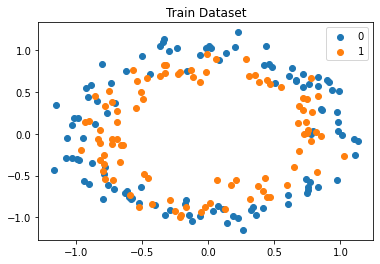

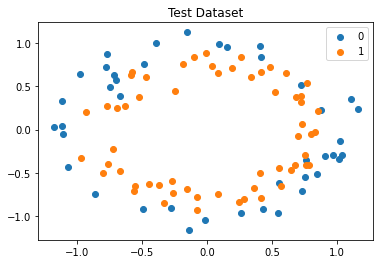

In [4]:
plotDataset(trX, trY,'Train Dataset')
plotDataset(teX, teY, 'Test Dataset')

> From the figures, we observe that the dataset has circular nature. To classify it, non-linear algorithms are preferred.
> 
> In this project, we are going to try three algorithms :
> * Decision Trees
> * Bagging algorithms based on Decision Trees
> * Boosting Algorithms

# Decision Trees

# Fit decision tree model on the training data.

In [5]:
clf = tree.DecisionTreeClassifier()
clf.fit(trX,trY)

DecisionTreeClassifier()

> Ploting the resulted tree with "graphiviz" library

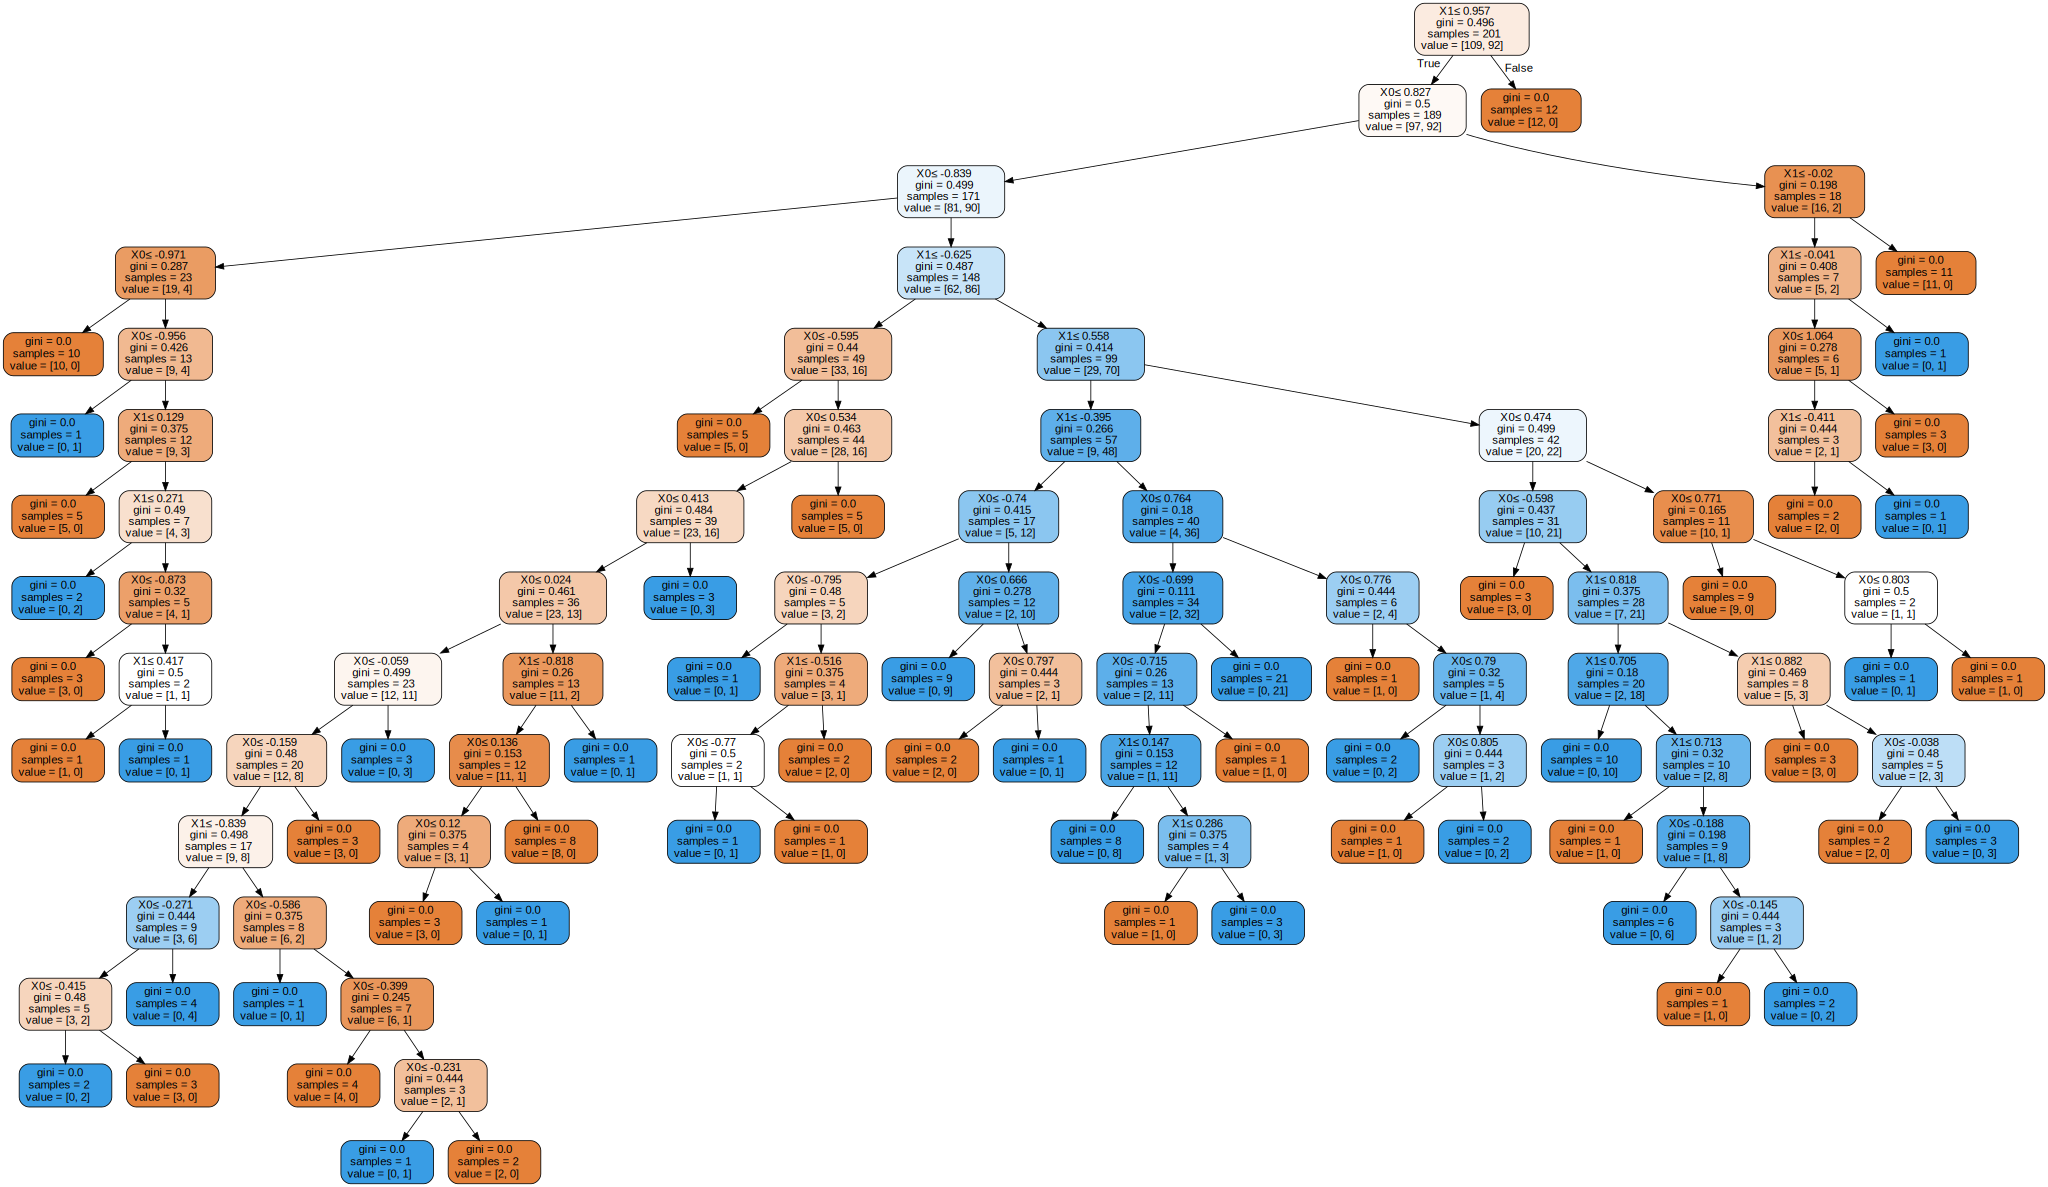

In [6]:

dot_data = tree.export_graphviz(clf, out_file=None, filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("make_circle") #to save the tree as pdf format
graph

# Classify the labels of test set from the resulted classifier.

In [7]:
clf_labels = clf.predict(teX)
clf_labels

array([1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1])

# Calculating the accuracy of the classifier on test labels.

In [8]:
dec_accuracy = metrics.accuracy_score(teY , clf_labels)
print(f'The accuracy of the Decision Tree Classifier = {dec_accuracy * 100:.2f}%')

The accuracy of the Decision Tree Classifier = 62.63%


# Confusion matrix on train data & test data

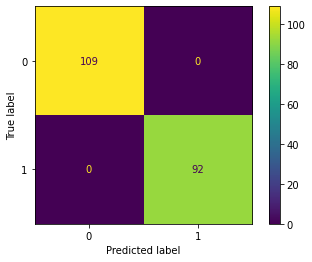

In [9]:
metrics.plot_confusion_matrix(clf,trX , trY) #confusion matrix of the training

In [10]:
metrics.confusion_matrix(teY , clf_labels) #confusion matrix of test data

array([[27, 14],
       [23, 35]])

> From the confusion matrix of training data, we observe that there is no bias in the results and it predicts all labels in a perfect way. However, in the test data the classifier has low accuracy and misclassifies (14 + 19 = 33)examples from 99 examples. The results shows the problem of Decision tree which is the Overfitting.

# Plotting the decision boundary of the decision trees classifier.

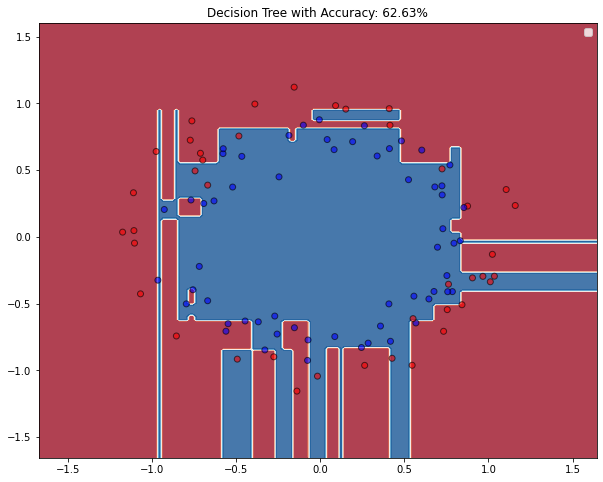

In [11]:
plotEstimator(trX, trY, teX, teY, clf, title = f'Decision Tree with Accuracy: {dec_accuracy * 100:.2f}%')

> From the figure, we observe that the resulted accuracy = 66.67%, the classes are seperated but there are some labels that are misclassified specially the red labels.

> Misclassified red labels (badly classified) >> Misclassified blue labels (classified well)

# Bagging

# Bagging algorithm from scratch

In [12]:
# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
    # count all samples at split point
    n_instances = float(sum([len(group) for group in groups]))
    # sum weighted Gini index for each group
    gini = 0.0
    for group in groups:
        size = float(len(group))
        # avoid divide by zero
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        # weight the group score by its relative size
        gini += (1.0 - score) * (size / n_instances)
    return gini

# Select the best split point for a dataset
def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

# Create a terminal node value
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

# Build a decision tree (base estimator)
def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

# Make a prediction with a decision tree
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

# Create a random subsample from the dataset with replacement
def subsample(dataset, ratio):
    sample = list()
    n_sample = round(len(dataset) * ratio)
    while len(sample) < n_sample:
        index = randrange(len(dataset))
        sample.append(dataset[index])
    return sample

# Make a prediction with a list of bagged trees
def bagging_predict(trees, row):
    predictions = [predict(tree, row) for tree in trees]
    return max(set(predictions), key=predictions.count) #max voting decision

# Bootstrap Aggregation Algorithm
def bagging(train, max_depth, min_size, sample_size, n_trees):
    trees = list()
    for i in range(n_trees):
        sample = subsample(train, sample_size)
        tree = build_tree(sample, max_depth, min_size)
        trees.append(tree)
    return trees

# Decision boundary plot function of bagging algorithm.

In [13]:
def plotBagEstimator(teX, teY,trees,title=''):
    plt.figure(figsize = (10,8))
    h = .02
    x_min, x_max = teX[:, 0].min() - .5, teX[:, 0].max() + .5
    y_min, y_max = teX[:, 1].min() - .5, teX[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    pred = [bagging_predict(trees, row) for row in np.c_[xx.ravel() , yy.ravel()]]
    Z = np.array(pred).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cm, alpha=0.8)
    plt.scatter(teX[:, 0], teX[:, 1], c=teY, cmap=cm_bright, edgecolors='k', alpha=0.6)
    plt.legend()
    plt.title(title)
    plt.show()

# The accuracy and Decision boundary of bagging algorithm with varying number of trees.

> Number of trees = {2 , 5 , 10 , 20}

The confusion matrix of test data: 
 [[35  6]
 [34 24]]
Number of trees = 2
Accuracy = 59.60%


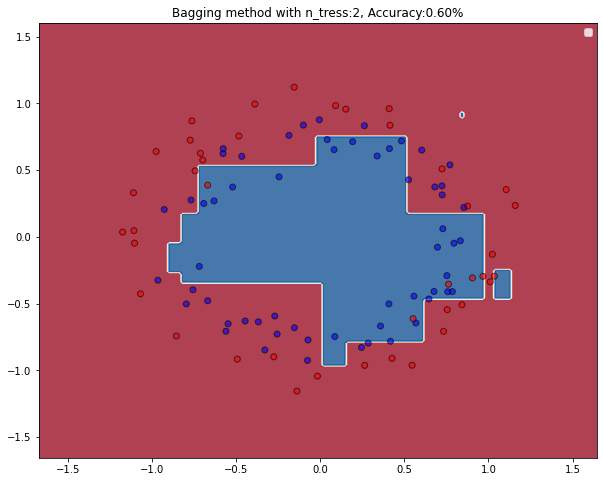

The confusion matrix of test data: 
 [[31 10]
 [24 34]]
Number of trees = 5
Accuracy = 65.66%


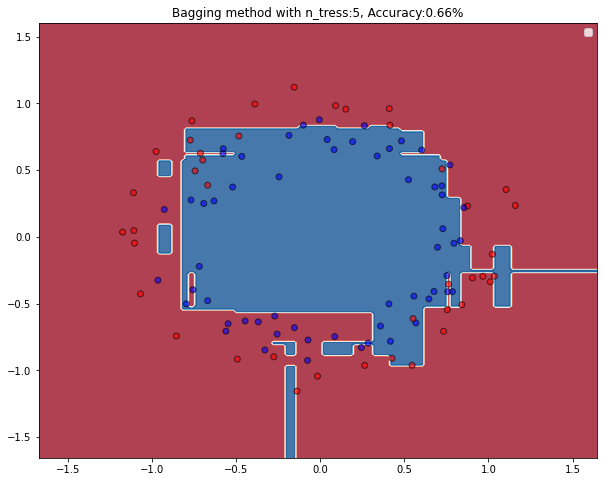

The confusion matrix of test data: 
 [[32  9]
 [14 44]]
Number of trees = 15
Accuracy = 76.77%


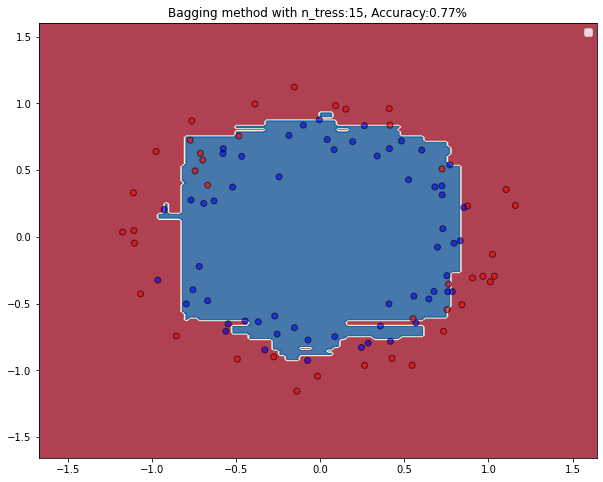

The confusion matrix of test data: 
 [[29 12]
 [17 41]]
Number of trees = 20
Accuracy = 70.71%


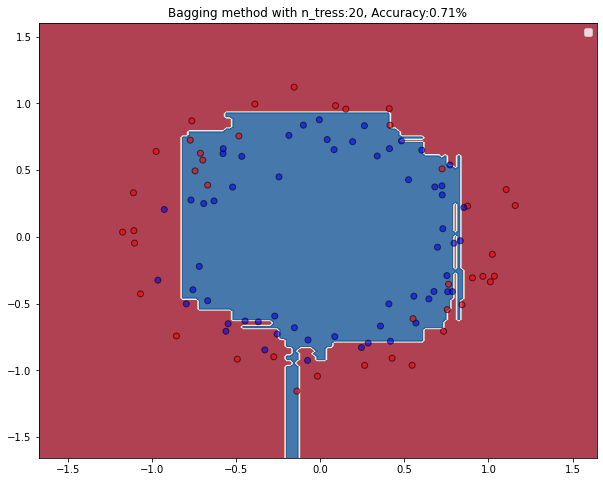

In [14]:
#setting the parameters
max_depth = 6
min_size = 2
sample_size = 0.50
n_trees_list = [2, 5, 15, 20]
# acc_list = []
bagg_data = []

train_set = np.concatenate((trX, trY.reshape(trY.shape[0], 1)), axis=1)
test_set = np.concatenate((teX, teY.reshape(teY.shape[0], 1)), axis=1)
for n_trees in n_trees_list:
    trees =  bagging(train_set,max_depth, min_size, sample_size, n_trees)
    pred = [bagging_predict(trees, row) for row in test_set]
    accuracy = metrics.accuracy_score(teY, pred)
    bagg_data.append((n_trees,accuracy))
    print(f'The confusion matrix of test data: \n',metrics.confusion_matrix(teY , pred))
    print(f'Number of trees = {n_trees}')
    print(f'Accuracy = {accuracy *100:.2f}%')
    plotBagEstimator(teX,teY,trees,title = f'Bagging method with n_tress:{n_trees}, Accuracy:{accuracy:.2f}%')

# Dataframe with the final results of accuracy with varying the number of trees.

In [15]:
bagg_df = pd.DataFrame(bagg_data,columns = ['Number of trees' , 'Accuracy'])
bagg_df

,Number of trees,Accuracy
0,2,0.595960
1,5,0.656566
2,15,0.767677
3,20,0.707071


> From the Resulted confusion matrix and accuracy, we observe that the accuracy on test data increases with increasing number of trees. there is no notable difference between n_trees = 15 & n_trees = 20.

# Q5: Explain why bagging can reduce the variance and mitigate the overfitting problem.

> https://towardsdatascience.com/understanding-the-effect-of-bagging-on-variance-and-bias-visually-6131e6ff1385

> Decision trees are built on the node purity since there are no assumptions are assumed, therefore it has a low bias. Beacuse of bagging algorithm is the averaging of a group of decision trees models that are being ran on a randomly drawn training dataset (sampling a function from a distribution), it inherits the low bias from decision trees. in addition, bagging reduces the variance because by averaging the outputs of N trees, the variance of the final prediction is given by: ((p*sigma^2) + ((1-p)*sigma^2)) / N, where p represents the pairwise correlation between trees, nad sigma^2 represents the variance. So, for large N the right term vanishes, therefore the variance reduced to (p* sigma^2).

# Boosting

# Setting the parameters

In [16]:
n_estimators = [10 , 50 , 100 , 200]
learning_rate = [0.1 , 1 , 2]
boost_data = []

# Applying boosting algorithm with different parameters (number of estimators , learning rate)

The confusion matrix on Test data: 
 [[30 11]
 [18 40]]

The confusion matrix of training: 



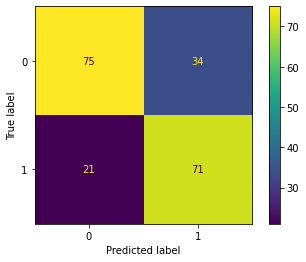

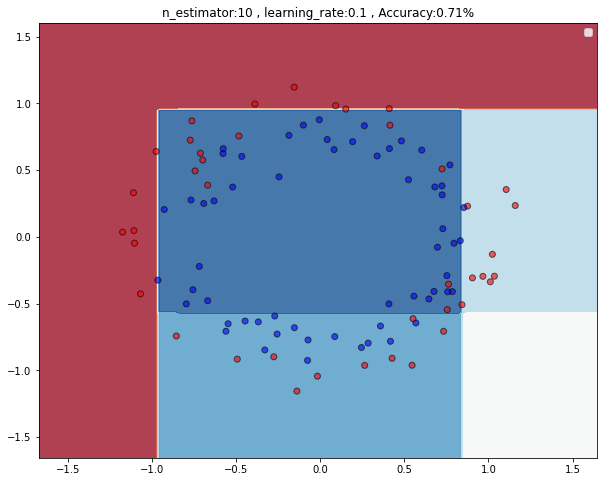

The confusion matrix on Test data: 
 [[30 11]
 [19 39]]

The confusion matrix of training: 



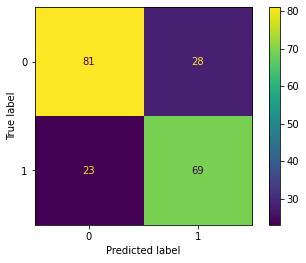

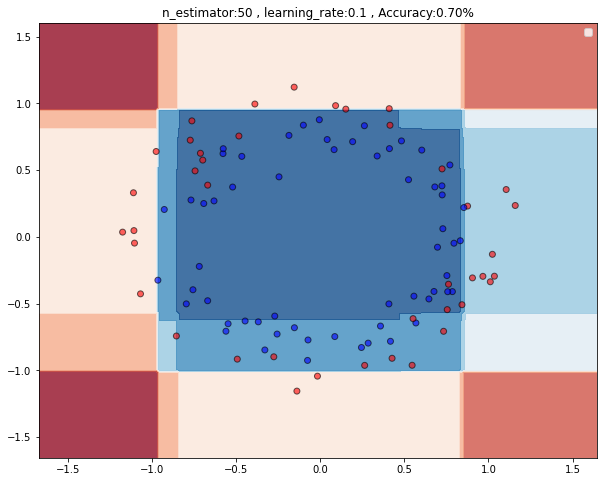

The confusion matrix on Test data: 
 [[33  8]
 [24 34]]

The confusion matrix of training: 



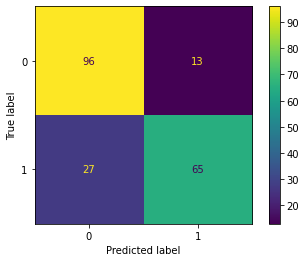

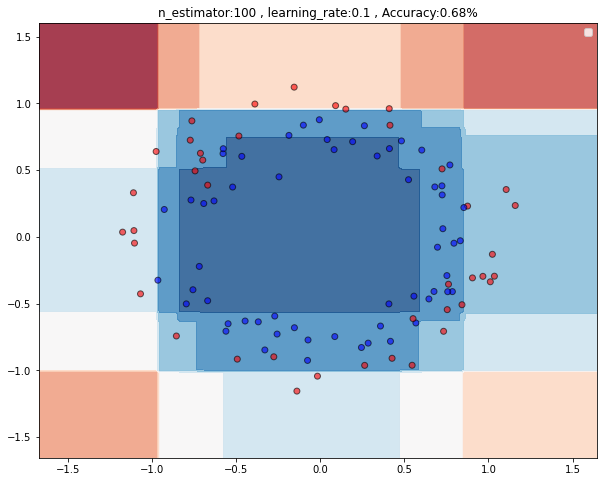

The confusion matrix on Test data: 
 [[35  6]
 [24 34]]

The confusion matrix of training: 



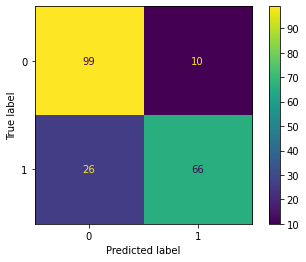

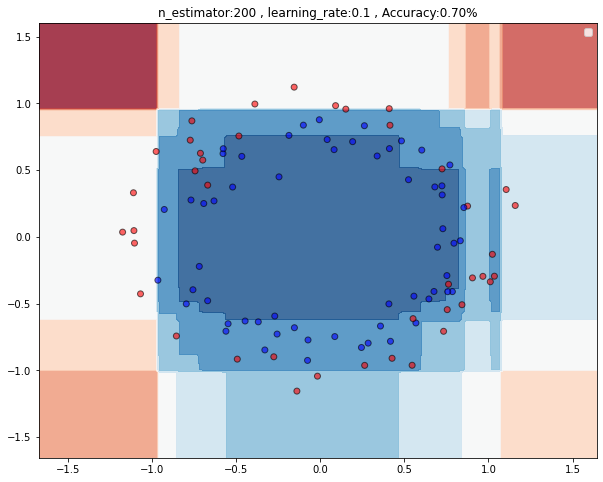

The confusion matrix on Test data: 
 [[32  9]
 [23 35]]

The confusion matrix of training: 



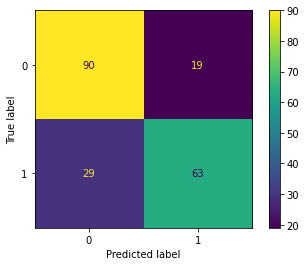

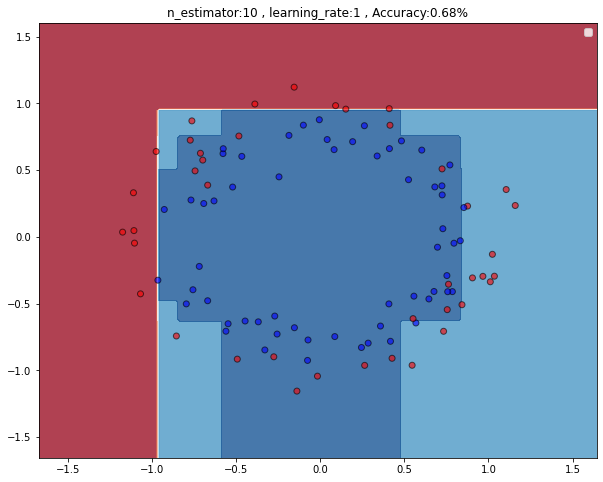

The confusion matrix on Test data: 
 [[34  7]
 [12 46]]

The confusion matrix of training: 



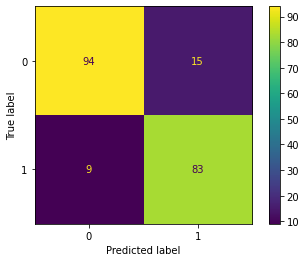

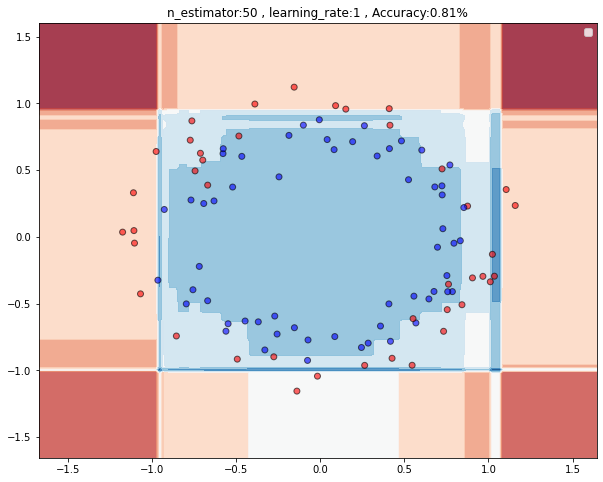

The confusion matrix on Test data: 
 [[33  8]
 [11 47]]

The confusion matrix of training: 



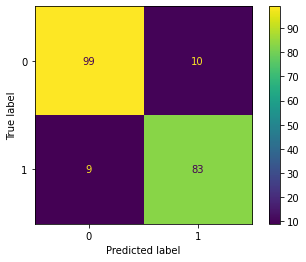

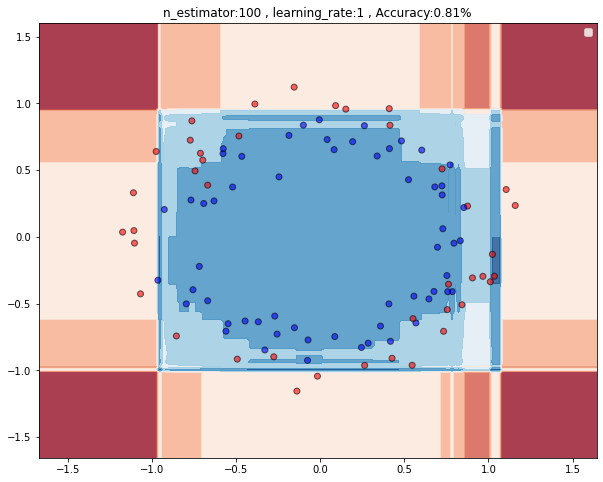

The confusion matrix on Test data: 
 [[33  8]
 [12 46]]

The confusion matrix of training: 



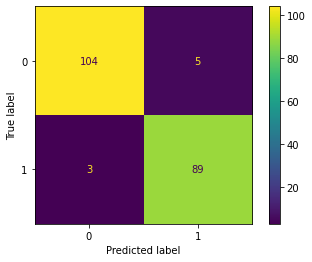

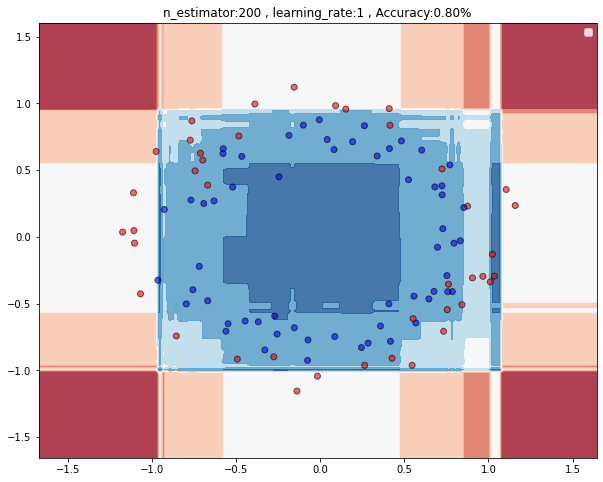

The confusion matrix on Test data: 
 [[29 12]
 [20 38]]

The confusion matrix of training: 



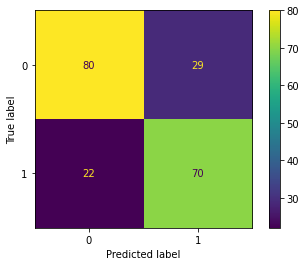

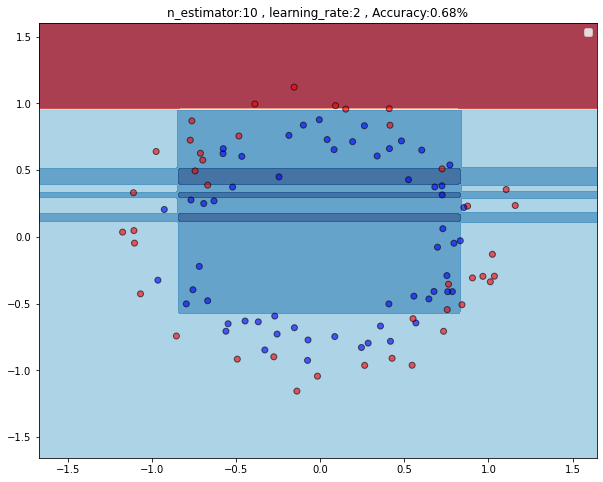

The confusion matrix on Test data: 
 [[25 16]
 [31 27]]

The confusion matrix of training: 



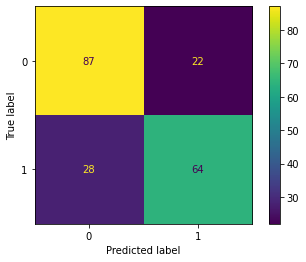

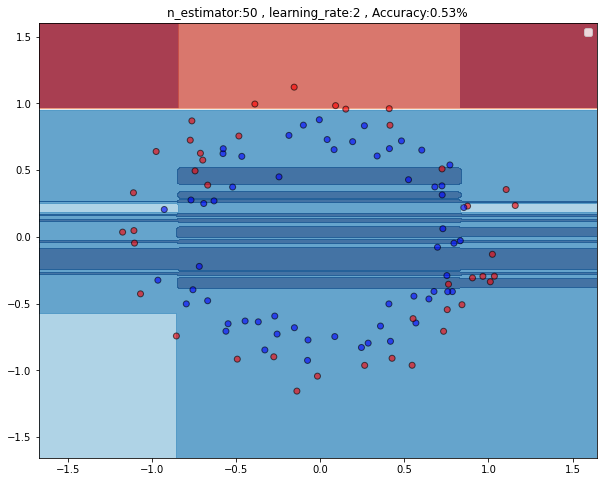

The confusion matrix on Test data: 
 [[28 13]
 [22 36]]

The confusion matrix of training: 



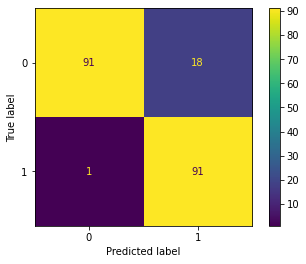

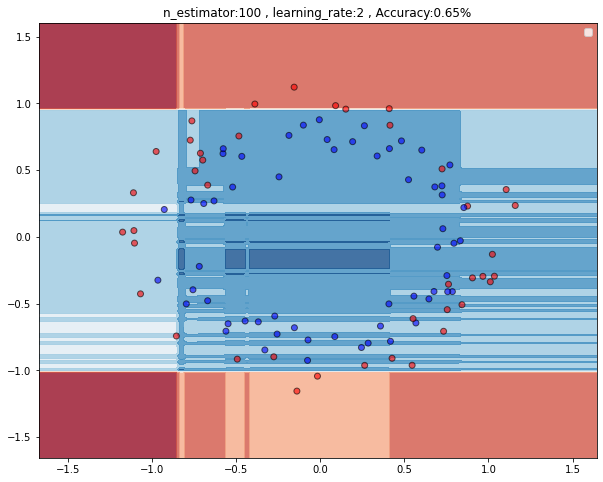

The confusion matrix on Test data: 
 [[30 11]
 [20 38]]

The confusion matrix of training: 



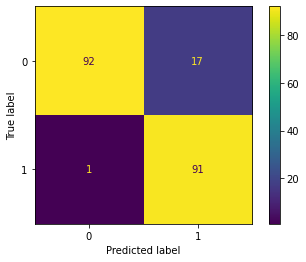

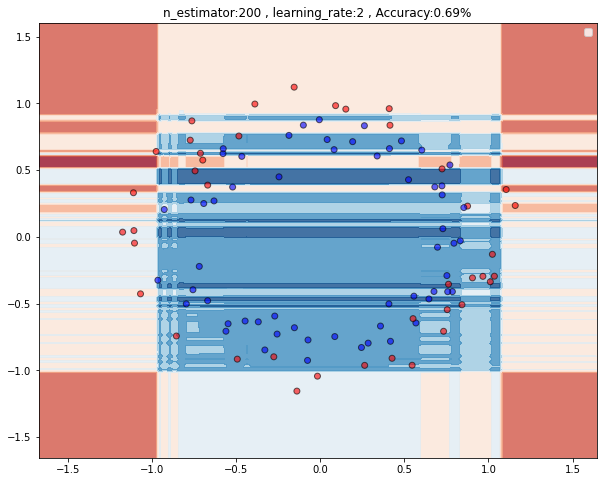

In [17]:
for lr in range (len(learning_rate)):
    for ne in range(len(n_estimators)):
        clf = AdaBoostClassifier(n_estimators = n_estimators[ne],learning_rate = learning_rate[lr])
        clf.fit(trX , trY)
        clf_labels = clf.predict(teX)
        clf_accuracy = metrics.accuracy_score(teY , clf_labels)
        boost_data.append((n_estimators[ne],learning_rate[lr],clf_accuracy))
        print(f'The confusion matrix on Test data: \n', metrics.confusion_matrix(teY , clf_labels))
        print('\nThe confusion matrix of training: \n')
        metrics.plot_confusion_matrix(clf,trX , trY)
        plotEstimator(trX, trY, teX, teY, clf, title = f'n_estimator:{n_estimators[ne]} , learning_rate:{learning_rate[lr]} , Accuracy:{clf_accuracy:.2f}%')


# Dataframe with the final results of accuracy with varying the number of estimators and learning rate.

In [18]:
boost_df = pd.DataFrame(boost_data,columns = ['n_estimators','learning_rate','Accuracy'])
boost_df

,n_estimators,learning_rate,Accuracy
0,10,0.1,0.707071
1,50,0.1,0.696970
2,100,0.1,0.676768
3,200,0.1,0.696970
4,10,1.0,0.676768
5,50,1.0,0.808081
6,100,1.0,0.808081
7,200,1.0,0.797980
8,10,2.0,0.676768
9,50,2.0,0.525253


> The results shows that the accuracy increases with increasing number of estimators when the value of the learning rate isnot too small or too large, but it saturated at a value of n_estimators there is not any notable enhancement in the results after it. in addition, it may cause overfitting . when the learning rate is too small, we don't need to increase number of estimators. When the learning rate is large, we need to increase number of estimators to reduce the bias. 

# References:

> https://machinelearningmastery.com/implement-bagging-scratch-python/

> https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205

> https://blog.paperspace.com/bagging-ensemble-methods/

> https://towardsdatascience.com/understanding-the-effect-of-bagging-on-variance-and-bias-visually-6131e6ff1385